# Simulation of different circuit perparation of GKP codes

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import optimization
import evaluation
import pandas as pd
import strawberryfields as sf

/Users/etiennestock/Documents/packages/strawberryfields/strawberryfields/apps/data/sample.py:20: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
# general stuff
state_dict = {(0, 0): '0', (np.pi, 0): '1', (np.pi/2, 0): '+'} # dictionary to save the state properly

def Vtanhgate(s): return sf.ops.Vgate(np.tanh(s)) 
def Kdl2c2gate(kappa): return sf.ops.Kdlcgate(kappa, 2, 2)
def Kdl6c2gate(kappa): return sf.ops.Kdlcgate(kappa, 6, 2)
def Kdl10c2gate(kappa): return sf.ops.Kdlcgate(kappa, 10, 2)

In [3]:
# hyperparameters of the current run
cutoff     = 60
delta      = 0.25 
epsilon    = delta**2 
num_trials = 4 
n_jobs     = 2 
state      = [0, 0] 
num_blocks = [15] 
circuits   = ['XRKd6S']
gates      = [
    np.array([sf.ops.Xgate, sf.ops.Rgate, sf.ops.Kdrivengate, sf.ops.Sgate])
] 
rev_gates  = [
    np.array([sf.ops.Sgate, sf.ops.Kdrivengate, sf.ops.Rgate, sf.ops.Xgate])
]

In [4]:
# arrays to store data for plots and error analysis 
max_params = max(num_blocks)*max(len(gate) for gate in gates)
opt        = np.empty(len(circuits), dtype=optimization.Optimization)
Fids       = np.empty((len(circuits), num_trials), dtype=np.float32)
Sols       = np.empty((len(circuits), num_trials, max_params), dtype=np.float32)
bestFids   = np.empty(len(circuits), dtype=np.float32) 

# parallel optimization
for i in range(len(circuits)): 
    opt[i] = optimization.Optimization(gates=gates[i], circuit=circuits[i], cutoff=cutoff, delta=delta, epsilon=epsilon, num_blocks=num_blocks[i], num_trials=num_trials, state=state)
    Fids[i], Sols[i,:,:num_blocks[i]*len(gates[i])] = opt[i].parallel_optimize_circuit()   
    bestFids[i] = opt[i].get_bestFid()
    print(f'{i}. optimization done!')

# store data in pandas data frame
results = pd.DataFrame(data=np.array([circuits] + list([Fids[:,i] for i in range(num_trials)]) + list([bestFids])).T, columns=['method'] + [(f'{i+1}: ' + r'$\left|\left<0\right| U(\vec{\lambda})\left|\Psi_t \right>\right|^2$') for i in range(num_trials)] + [r'$\max_i\left|\left<0\right| U(\vec{\lambda})\left|\Psi_t \right>\right|^2$'])

0. optimization done!


In [5]:
# save data in folder data
for i in range(len(circuits)): 
    file_name = f"data_{state_dict[tuple(state)]}_{circuits[i]}_{cutoff}_{str(delta).replace('.', '')}_{num_blocks[i]}"
    opt[i].save(file_name)

In [6]:
# prepare the target state in Fock basis, so that we can compare with our generated state
target_GKP = evaluation.prepare_GKP(epsilon=epsilon, cutoff=cutoff, state=state).ket()

# compute norm of the generated states and the fidelity between target state and generated state
generated_GKP = np.empty((len(circuits), cutoff), dtype=np.complex64)
normgen       = np.empty(len(circuits), dtype=np.float32)
fid           = np.empty(len(circuits), dtype=np.float32)

for i in range(len(circuits)):    
    generated_GKP[i] = evaluation.prepare_state(rev_gates[i], -np.flip(opt[i].get_bestSol()), cutoff).ket()
    normgen[i]       = np.dot(generated_GKP[i].conj(), generated_GKP[i])
    fid[i]           = np.abs(np.dot(generated_GKP[i].conj(), target_GKP))**2

# add results
results[r'$|\langle\Psi_g|\Psi_g\rangle|^2$'] = normgen
results[r'$|\langle\Psi_g|\Psi_t\rangle|^2$'] = fid

/var/folders/6q/7zspg0xj68g0zq09v2tt_hyh0000gn/T/ipykernel_33221/3565388830.py:10: ComplexWarning: Casting complex values to real discards the imaginary part


In [7]:
# calculate the norm of the target state for consistency
normtarg = np.abs(np.dot(target_GKP.conj(), target_GKP))
pd.DataFrame([normtarg], [r'$\left|\left<\Psi_t |\Psi_t \right>\right|^2$'])

,0
$\left|\left<\Psi_t |\Psi_t \right>\right|^2$,1.0


In [8]:
# show results of this optimization round
results

,method,1: $\left|\left<0\right| U(\vec{\lambda})\left|\Psi_t \right>\right|^2$,2: $\left|\left<0\right| U(\vec{\lambda})\left|\Psi_t \right>\right|^2$,3: $\left|\left<0\right| U(\vec{\lambda})\left|\Psi_t \right>\right|^2$,4: $\left|\left<0\right| U(\vec{\lambda})\left|\Psi_t \right>\right|^2$,$\max_i\left|\left<0\right| U(\vec{\lambda})\left|\Psi_t \right>\right|^2$,$|\langle\Psi_g|\Psi_g\rangle|^2$,$|\langle\Psi_g|\Psi_t\rangle|^2$
0,XRKd6S,0.050675128,0.03161994,0.08863347,0.10438837,0.10438837,0.919074,0.104388


<>:17: SyntaxWarning: invalid escape sequence '\P'
<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\P'
<>:19: SyntaxWarning: invalid escape sequence '\s'
/var/folders/6q/7zspg0xj68g0zq09v2tt_hyh0000gn/T/ipykernel_33221/2402360986.py:17: SyntaxWarning: invalid escape sequence '\P'
/var/folders/6q/7zspg0xj68g0zq09v2tt_hyh0000gn/T/ipykernel_33221/2402360986.py:19: SyntaxWarning: invalid escape sequence '\s'


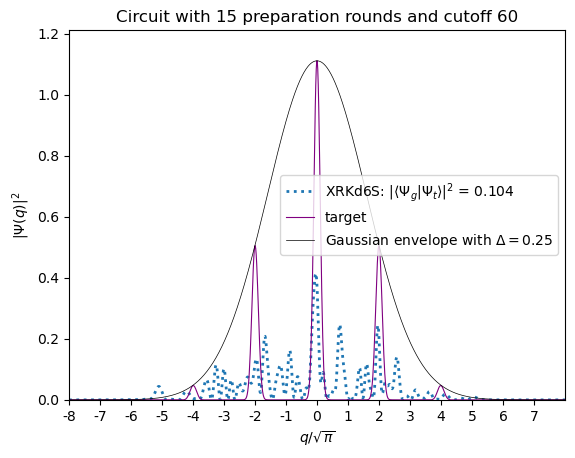

In [9]:
# Plot probability distribution of generated and target GKP states
qnum    = 8
qlim    = qnum*np.sqrt(np.pi)
qvalues = np.linspace(-qlim,qlim, 1000)

targetGKPwf = evaluation.wavefunction(q=qvalues, ket=target_GKP)
gauss       = lambda x: np.max(np.abs(targetGKPwf*targetGKPwf.conj())) * np.exp(-x**2*(delta)**2)

genGKPwf    = np.empty((len(circuits), 1000), dtype=np.complex64)
for i in range(len(circuits)):
    genGKPwf[i] = evaluation.wavefunction(q=qvalues, ket=generated_GKP[i])
    plt.plot(qvalues, np.abs(genGKPwf[i]*genGKPwf[i].conj()), label=f'{circuits[i]}: '+r'$|\langle\Psi_g|\Psi_t\rangle|^2$'+f' = {fid[i]:.3f}', linestyle='dotted', linewidth=2)

plt.plot(qvalues, np.abs(targetGKPwf*targetGKPwf.conj()), label='target', color='purple', linewidth=0.8)
plt.plot(qvalues, gauss(qvalues), label=r'Gaussian envelope with $\Delta =$'+f'{delta}', color='black', linewidth=0.5)

plt.ylabel("$|\Psi(q)|^2$")
plt.xticks(np.sqrt(np.pi)*np.arange(-qnum, qnum), np.arange(-qnum, qnum))
plt.xlabel("$q/\sqrt{\pi}$")
plt.xlim(np.min(qvalues), np.max(qvalues))
plt.ylim(0, np.max(np.abs(targetGKPwf*targetGKPwf.conj()))+0.1)
plt.title(f'Circuit with {np.max(num_blocks)} preparation rounds and cutoff {cutoff}')
plt.legend()

plt.savefig(f'plots/plot_{cutoff}_{str(delta).replace(".", "")}_{np.max(num_blocks)}_' + '_'.join(str(c) for c in circuits) + '.png')
plt.show()

In [10]:
# calculate the Knill-Glancy error
n    = 30 
size = 30 

results[r'$P_{\text{error}}$'] = np.empty(len(circuits), dtype=np.float32)
for i in range(len(circuits)): 
    results.loc[i, r'$P_{\text{error}}$'] = evaluation.error_gancy_knill(generated_GKP[i], n, size)

/var/folders/6q/7zspg0xj68g0zq09v2tt_hyh0000gn/T/ipykernel_33221/1311979444.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.890952557848503' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.


In [11]:
results

,method,1: $\left|\left<0\right| U(\vec{\lambda})\left|\Psi_t \right>\right|^2$,2: $\left|\left<0\right| U(\vec{\lambda})\left|\Psi_t \right>\right|^2$,3: $\left|\left<0\right| U(\vec{\lambda})\left|\Psi_t \right>\right|^2$,4: $\left|\left<0\right| U(\vec{\lambda})\left|\Psi_t \right>\right|^2$,$\max_i\left|\left<0\right| U(\vec{\lambda})\left|\Psi_t \right>\right|^2$,$|\langle\Psi_g|\Psi_g\rangle|^2$,$|\langle\Psi_g|\Psi_t\rangle|^2$,$P_{\text{error}}$
0,XRKd6S,0.050675128,0.03161994,0.08863347,0.10438837,0.10438837,0.919074,0.104388,0.890953
